In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

In [2]:
base_path = "/Users/sayan/CMB_WORK/Maps/"

cl_th = np.loadtxt(base_path + "COM_PowerSpect_CMB-base-plikHM-TTTEEE-lowl-lowE-lensing-minimum-theory_R3.01.txt")

halfmap1_t = hp.read_map(base_path + "COM_CMB_IQU-smica_2048_R3.00_hm1.fits", field=0)
halfmap2_t = hp.read_map(base_path + "COM_CMB_IQU-smica_2048_R3.00_hm2.fits", field=0)
data_t = hp.read_map(base_path + "COM_CMB_IQU-smica_2048_R3.00_full.fits", field=0)
mask_t = hp.read_map(base_path + "COM_CMB_IQU-smica_2048_R3.00_full.fits", field=3)

halfmap1_q = hp.read_map(base_path + "COM_CMB_IQU-smica_2048_R3.00_hm1.fits", field=1)
halfmap2_q = hp.read_map(base_path + "COM_CMB_IQU-smica_2048_R3.00_hm2.fits", field=1)
data_q = hp.read_map(base_path + "COM_CMB_IQU-smica_2048_R3.00_full.fits", field=1)

halfmap1_u = hp.read_map(base_path + "COM_CMB_IQU-smica_2048_R3.00_hm1.fits", field=2)
halfmap2_u = hp.read_map(base_path + "COM_CMB_IQU-smica_2048_R3.00_hm2.fits", field=2)
data_u = hp.read_map(base_path + "COM_CMB_IQU-smica_2048_R3.00_full.fits", field=2)

mask_p = hp.read_map(base_path + "COM_CMB_IQU-smica_2048_R3.00_full.fits", field=4)

SMICA Resolutions: https://wiki.cosmos.esa.int/planckpla/index.php/CMB_and_astrophysical_component_maps#SMICA 

Polarisation: https://wiki.cosmos.esa.int/planck-legacy-archive/index.php/CMB_maps#SMICA

Beam: https://healpy.readthedocs.io/en/latest/generated/healpy.sphtfunc.gauss_beam.html

In [36]:
elmax = 2048
nside = 2048
beam_arcmin = 5
npix = hp.nside2npix(nside)
pixwin = hp.pixwin(2048, lmax=elmax)
beam_l = hp.gauss_beam(np.radians(beam_arcmin/60), lmax=elmax,pol=True)[:,3]
bl_pix = beam_l/pixwin

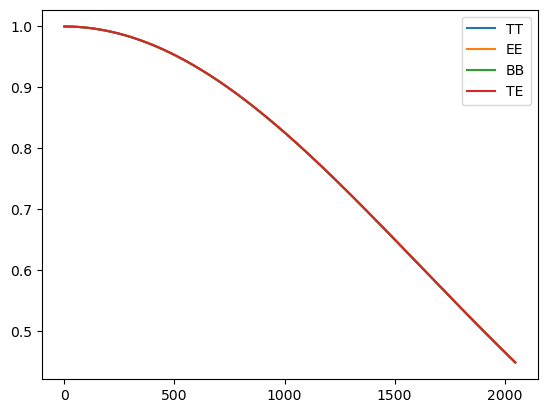

In [48]:
# plot all the beam component

beam_l = hp.gauss_beam(np.radians(5/60), lmax=elmax,pol=True)
plt.plot(beam_l[:,0], label='TT')
plt.plot(beam_l[:,1], label='EE')
plt.plot(beam_l[:,2], label='BB')
plt.plot(beam_l[:,3], label='TE')
plt.legend()
plt.savefig("./plots/beam_5arcmin.pdf")
plt.show()


In [4]:
maps=np.ndarray(shape=(3,npix))
maps[0,:] = data_t
maps[1,:] = data_q
maps[2,:] = data_u

hp.map2alm: https://healpy.readthedocs.io/en/latest/generated/healpy.sphtfunc.map2alm.html

In [5]:
#getting alms,elm and blm for full mission
alms = hp.map2alm(maps,pol=True,lmax=elmax)
tmap = hp.alm2map(alms[0,:],pol=False,lmax=elmax,nside=nside) #check if mask needs to be mutilplied here as well
emap = hp.alm2map(alms[1,:],pol=False,lmax=elmax,nside=nside) #check if mask needs to be mutilplied here as well
#bmap = hp.alm2map(alms[2,:],pol=False,lmax=elmax,nside=nside)

In [6]:
mask_c = mask_t*mask_p #combined mask
count_of_ones = np.count_nonzero(mask_c == 1)
fsky = count_of_ones/(len(mask_c))
print("The available sky fraction: ", fsky)

The available sky fraction:  0.8224528034528097


In [7]:
hmaps1=np.ndarray(shape=(3,npix))
hmaps1[0,:] = halfmap1_t
hmaps1[1,:] = halfmap1_q
hmaps1[2,:] = halfmap1_u

#getting alms,elm and blm for half mission 1
alms = hp.map2alm(hmaps1,pol=True,lmax=elmax)
tmap1 = halfmap1_t
emap1 = hp.alm2map(alms[1,:],pol=False,lmax=elmax,nside=nside) #check if mask needs to be mutilplied here as well
#bmap1 = hp.alm2map(alms[2,:],pol=False,lmax=elmax,nside=nside)

In [9]:
hmaps2=np.ndarray(shape=(3,npix))
hmaps2[0,:] = halfmap2_t
hmaps2[1,:] = halfmap2_q
hmaps2[2,:] = halfmap2_u

#getting alms,elm and blm for half mission 2
alms = hp.map2alm(hmaps2,pol=True,lmax=elmax)
tmap2 = halfmap2_t
emap2 = hp.alm2map(alms[1,:],pol=False,lmax=elmax,nside=nside) #check if mask needs to be mutilplied here as well
#bmap2 = hp.alm2map(alms[2,:],pol=False,lmax=elmax,nside=nside)

In [39]:
var2_e = (emap1-emap2)/2
var1_e = (emap1+emap2)/2
var2_t = (tmap1-tmap2)/2
var1_t = (tmap1+tmap2)/2
Nl = hp.anafast(var2_e*mask_c, var2_t*mask_c, lmax=elmax)/ (fsky * bl_pix**2) *1e12
Dl = hp.anafast(var1_e*mask_c, var1_t*mask_c, lmax=elmax)/ (fsky * bl_pix**2) *1e12
signal = Dl - Nl

In [37]:
signal1 = hp.anafast(emap1*mask_c, tmap2*mask_c, lmax=elmax)/ (fsky * bl_pix**2) *1e12

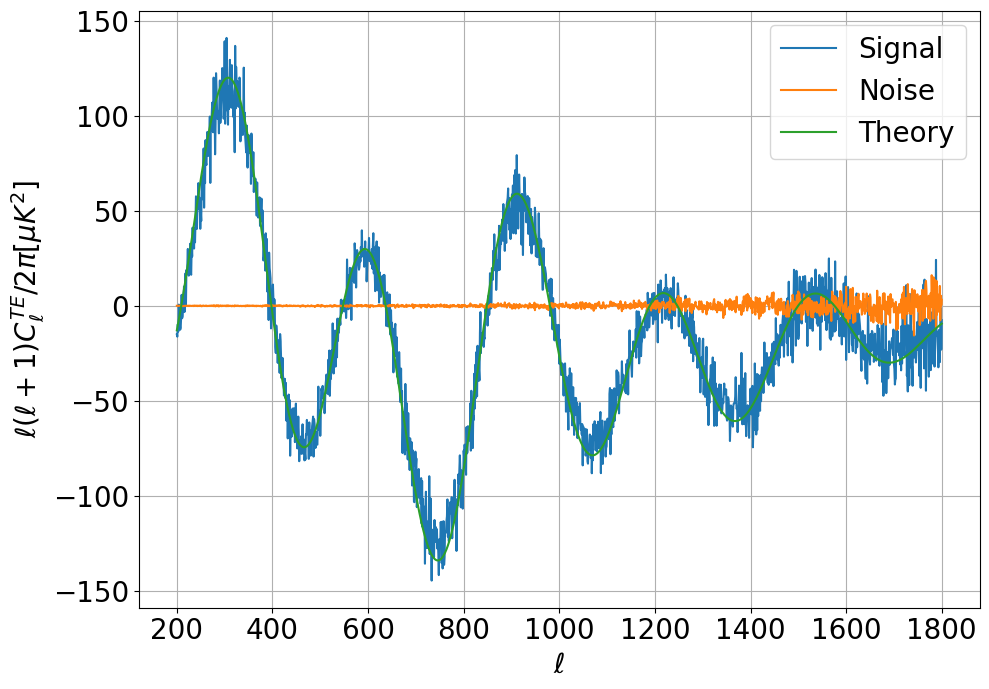

In [49]:
# Sample data for illustration
el = np.arange(200, 1800 + 1)

fig, ax1 = plt.subplots(figsize=(10, 7))

# Plot Signal, Noise, and Theory
ax1.plot(el, el * (el + 1) * signal[el] / 2 / np.pi, label="Signal")
ax1.plot(el, el * (el + 1) * Nl[el] / 2 / np.pi, label="Noise")
ax1.plot(el, cl_th[el, 2], label="Theory")
ax1.set_xlabel(r"$\ell$", fontsize=20)
ax1.set_ylabel(r"$\ell(\ell+1)C^{TE}_{\ell}/2\pi [\mu K^2]$", fontsize=20)
ax1.grid()
ax1.legend(fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
plt.savefig("./plots/cross_power_spectrum_TE_beam5arcmin.pdf")
plt.show()
